In [1]:
# Cell 1: Performance Metrics Setup - FIXED VERSION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("📊 Volatility Estimators Project")
print("=================================")
print("Notebook 2: Performance Quantification")
print("Measuring Bias, MSE, and Efficiency")

np.random.seed(42)
plt.style.use('seaborn-v0_8')

# IMPORT THE CLASSES - ADD THIS PART
class VolatilityEstimators:
    """
    Implementation of 5 prominent volatility estimators
    """
    
    def __init__(self, window=30, trading_days=252):
        self.window = window
        self.trading_days = trading_days
    
    def close_to_close(self, closes):
        """Classical close-to-close estimator"""
        returns = np.log(closes / closes.shift(1)).dropna()
        recent_returns = returns.iloc[-self.window:]
        variance = np.var(recent_returns, ddof=1)
        return np.sqrt(variance * self.trading_days)
    
    def parkinson(self, highs, lows):
        """Parkinson (1980) - High/Low range estimator"""
        log_high = np.log(highs)
        log_low = np.log(lows)
        recent_high = log_high.iloc[-self.window:]
        recent_low = log_low.iloc[-self.window:]
        
        squared_ranges = (recent_high - recent_low) ** 2
        variance = (1 / (4 * self.window * np.log(2))) * np.sum(squared_ranges)
        return np.sqrt(variance * self.trading_days)
    
    def garman_klass(self, opens, highs, lows, closes):
        """Garman-Klass (1980) - OHLC estimator"""
        log_open = np.log(opens)
        log_high = np.log(highs)
        log_low = np.log(lows)
        log_close = np.log(closes)
        
        o = log_open.iloc[-self.window:]
        h = log_high.iloc[-self.window:]
        l = log_low.iloc[-self.window:]
        c = log_close.iloc[-self.window:]
        
        term1 = 0.5 * (h - l) ** 2
        term2 = (2 * np.log(2) - 1) * (c - o) ** 2
        variance = (1 / self.window) * np.sum(term1 - term2)
        return np.sqrt(variance * self.trading_days)
    
    def rogers_satchell(self, opens, highs, lows, closes):
        """Rogers-Satchell (1991) - Drift-robust estimator"""
        log_open = np.log(opens)
        log_high = np.log(highs)
        log_low = np.log(lows)
        log_close = np.log(closes)
        
        o = log_open.iloc[-self.window:]
        h = log_high.iloc[-self.window:]
        l = log_low.iloc[-self.window:]
        c = log_close.iloc[-self.window:]
        
        term1 = (h - c) * (h - o)
        term2 = (l - c) * (l - o)
        variance = (1 / self.window) * np.sum(term1 + term2)
        return np.sqrt(variance * self.trading_days)
    
    def yang_zhang(self, opens, highs, lows, closes):
        """Yang-Zhang (2000) - Handles drift and jumps"""
        if len(opens) < self.window + 1:
            raise ValueError(f"Need {self.window + 1} data points")
        
        log_open = np.log(opens)
        log_high = np.log(highs)
        log_low = np.log(lows)
        log_close = np.log(closes)
        
        # Overnight volatility
        overnight_returns = log_open.iloc[-self.window:] - log_close.iloc[-(self.window+1):-1].values
        var_overnight = np.var(overnight_returns, ddof=1)
        
        # Open-to-close volatility
        open_close_returns = log_close.iloc[-self.window:] - log_open.iloc[-self.window:]
        var_open_close = np.var(open_close_returns, ddof=1)
        
        # Rogers-Satchell component
        rs_variance = self.rogers_satchell(opens, highs, lows, closes) ** 2 / self.trading_days
        
        # Optimal weighting
        k = 0.34 / (1.34 + (self.window + 1) / (self.window - 1))
        variance = var_overnight + k * var_open_close + (1 - k) * rs_variance
        return np.sqrt(variance * self.trading_days)

class DataSimulator:
    """Simulate price paths with known true volatility"""
    
    def __init__(self, S0=100, mu=0.08, sigma=0.2, seed=42):
        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.seed = seed
        np.random.seed(seed)
    
    def simulate_gbm(self, n_days=252, dt=1/252):
        """Geometric Brownian Motion with true integrated variance"""
        mu_daily = self.mu * dt
        sigma_daily = self.sigma * np.sqrt(dt)
        true_variance = sigma_daily ** 2
        
        # Generate price path
        returns = np.random.normal(mu_daily, sigma_daily, n_days)
        prices = self.S0 * np.exp(np.cumsum(returns))
        prices = np.concatenate([[self.S0], prices])
        
        # Generate OHLC data
        ohlc = self._generate_ohlc(prices, sigma_daily)
        return ohlc, true_variance
    
    def _generate_ohlc(self, prices, daily_vol):
        """Generate realistic OHLC data from closing prices"""
        n_days = len(prices) - 1
        opens, highs, lows, closes = [], [], [], []
        
        for i in range(1, len(prices)):
            close_prev = prices[i-1]
            close_today = prices[i]
            
            # Realistic OHLC generation
            open_today = close_prev * (1 + np.random.normal(0, daily_vol/3))
            daily_range = np.abs(np.random.normal(0, daily_vol * 1.5))
            
            high_today = max(open_today, close_today) * (1 + daily_range)
            low_today = min(open_today, close_today) * (1 - daily_range)
            
            # Ensure high > low
            high_today = max(high_today, open_today, close_today)
            low_today = min(low_today, open_today, close_today)
            
            opens.append(open_today)
            highs.append(high_today)
            lows.append(low_today)
            closes.append(close_today)
        
        dates = pd.date_range(start='2020-01-01', periods=n_days, freq='D')
        return pd.DataFrame({'Open': opens, 'High': highs, 'Low': lows, 'Close': closes}, index=dates)

print("✅ All classes imported successfully!")

📊 Volatility Estimators Project
Notebook 2: Performance Quantification
Measuring Bias, MSE, and Efficiency
✅ All classes imported successfully!


In [2]:
# Cell 2: Performance Metrics Class
class PerformanceMetrics:
    """Quantify estimator performance using statistical metrics"""
    
    @staticmethod
    def bias(estimates, true_value):
        """Calculate bias: E[θ_hat] - θ"""
        return np.mean(estimates - true_value)
    
    @staticmethod
    def mse(estimates, true_value):
        """Calculate Mean Squared Error: E[(θ_hat - θ)²]"""
        return np.mean((estimates - true_value) ** 2)
    
    @staticmethod
    def rmse(estimates, true_value):
        """Calculate Root Mean Squared Error"""
        return np.sqrt(PerformanceMetrics.mse(estimates, true_value))
    
    @staticmethod
    def efficiency(estimates, benchmark_estimates):
        """Calculate relative efficiency: Var(benchmark) / Var(estimator)"""
        return np.var(benchmark_estimates) / np.var(estimates)
    
    @staticmethod
    def calculate_all_metrics(estimator_results, true_volatility, benchmark='Close-to-Close'):
        """Calculate all performance metrics for multiple estimators"""
        metrics_data = []
        
        for estimator_name, estimates in estimator_results.items():
            if len(estimates) > 0 and not np.all(np.isnan(estimates)):
                metrics_data.append({
                    'Estimator': estimator_name,
                    'Bias': PerformanceMetrics.bias(estimates, true_volatility),
                    'MSE': PerformanceMetrics.mse(estimates, true_volatility),
                    'RMSE': PerformanceMetrics.rmse(estimates, true_volatility),
                    'Efficiency': PerformanceMetrics.efficiency(estimates, estimator_results[benchmark]),
                    'Std_Dev': np.std(estimates),
                    'Mean_Estimate': np.mean(estimates)
                })
        
        return pd.DataFrame(metrics_data)

print("✅ Performance metrics defined")

✅ Performance metrics defined


In [3]:
# Cell 3: Run Large-Scale Simulation Study - FIXED VERSION
print("🏃 Running Large-Scale Simulation Study")
print("======================================")

n_simulations = 1000
window = 30
true_volatility = 0.20  # 20% annual volatility

# Storage for results
all_results = {
    'Close-to-Close': [],
    'Parkinson': [],
    'Garman-Klass': [], 
    'Rogers-Satchell': [],
    'Yang-Zhang': []
}

print(f"Running {n_simulations} simulations with {window}-day windows...")

for i in range(n_simulations):
    if i % 100 == 0:
        print(f"Progress: {i}/{n_simulations}")
    
    # Generate data with different seeds
    simulator = DataSimulator(sigma=true_volatility, seed=42+i)
    ohlc_data, true_variance = simulator.simulate_gbm(n_days=252)
    
    # Calculate all estimators - FIX THE TYPO HERE
    estimator = VolatilityEstimators(window=window)  # CHANGED: window=window instead of window-window
    
    try:
        all_results['Close-to-Close'].append(estimator.close_to_close(ohlc_data['Close']))
    except:
        all_results['Close-to-Close'].append(np.nan)
    
    try:
        all_results['Parkinson'].append(estimator.parkinson(ohlc_data['High'], ohlc_data['Low']))
    except:
        all_results['Parkinson'].append(np.nan)
    
    try:
        all_results['Garman-Klass'].append(estimator.garman_klass(ohlc_data['Open'], ohlc_data['High'], 
                                                                ohlc_data['Low'], ohlc_data['Close']))
    except:
        all_results['Garman-Klass'].append(np.nan)
    
    try:
        all_results['Rogers-Satchell'].append(estimator.rogers_satchell(ohlc_data['Open'], ohlc_data['High'],
                                                                      ohlc_data['Low'], ohlc_data['Close']))
    except:
        all_results['Rogers-Satchell'].append(np.nan)
    
    try:
        all_results['Yang-Zhang'].append(estimator.yang_zhang(ohlc_data['Open'], ohlc_data['High'],
                                                            ohlc_data['Low'], ohlc_data['Close']))
    except:
        all_results['Yang-Zhang'].append(np.nan)

print("✅ Simulation study completed")

🏃 Running Large-Scale Simulation Study
Running 1000 simulations with 30-day windows...
Progress: 0/1000
Progress: 100/1000
Progress: 200/1000
Progress: 300/1000
Progress: 400/1000
Progress: 500/1000
Progress: 600/1000
Progress: 700/1000
Progress: 800/1000
Progress: 900/1000
✅ Simulation study completed


In [4]:
# Cell 4: Calculate Performance Metrics
print("📈 Calculating Performance Metrics")
print("=================================")

# Convert to DataFrame for analysis
results_df = pd.DataFrame(all_results)

# Remove failed simulations
results_df_clean = results_df.dropna()
successful_simulations = len(results_df_clean)

print(f"Successful simulations: {successful_simulations}/{n_simulations}")

# Handle true_volatility - ensure it's a numpy array for vector operations
if np.isscalar(true_volatility):
    true_volatility_array = np.full(successful_simulations, true_volatility)
else:
    true_volatility_array = np.array(true_volatility)
    
print(f"True volatility array shape: {true_volatility_array.shape}")

# Convert estimator results to numpy arrays as well
estimator_results = {}
for col in results_df_clean.columns:
    estimator_results[col] = np.array(results_df_clean[col])
    
print(f"Number of estimators: {len(estimator_results)}")

# Calculate performance metrics
if successful_simulations > 0:
    metrics_calculator = PerformanceMetrics()
    performance_df = metrics_calculator.calculate_all_metrics(
        estimator_results,  # Pass numpy arrays instead of dict of lists
        true_volatility_array
    )
    
    print("\n📊 PERFORMANCE METRICS SUMMARY:")
    print("==============================")
    print(performance_df.round(6))
else:
    print("❌ No successful simulations to analyze!")
    performance_df = pd.DataFrame()


📈 Calculating Performance Metrics
Successful simulations: 1000/1000
True volatility array shape: (1000,)
Number of estimators: 5

📊 PERFORMANCE METRICS SUMMARY:
         Estimator      Bias       MSE      RMSE  Efficiency   Std_Dev  \
0   Close-to-Close -0.002374  0.000754  0.027463    1.000000  0.027360   
1        Parkinson  0.246649  0.063091  0.251180    0.331876  0.047493   
2     Garman-Klass  0.309134  0.098753  0.314250    0.234754  0.056469   
3  Rogers-Satchell  0.304131  0.095715  0.309378    0.232560  0.056735   
4       Yang-Zhang  0.278651  0.080325  0.283417    0.279436  0.051758   

   Mean_Estimate  
0       0.197626  
1       0.446649  
2       0.509134  
3       0.504131  
4       0.478651  


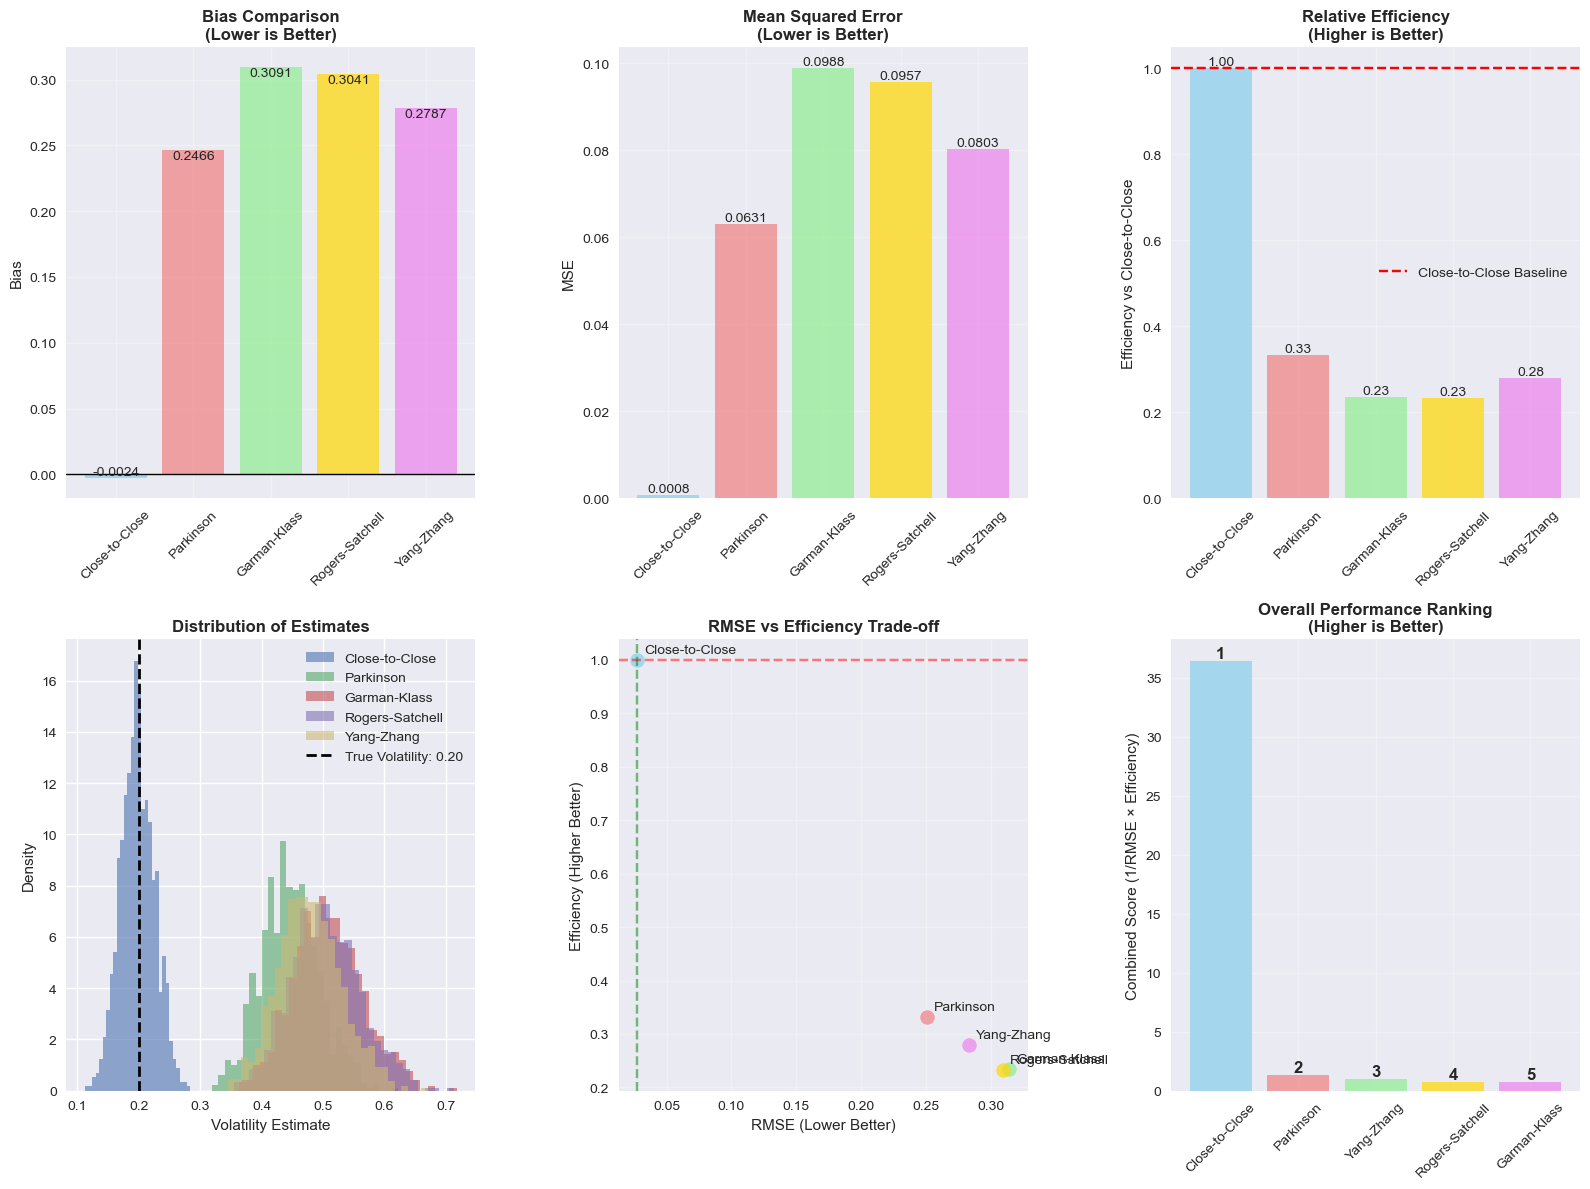

In [5]:
# Cell 5: Visualize Performance Results
plt.figure(figsize=(16, 12))

# Plot 1: Bias Comparison
plt.subplot(2, 3, 1)
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet']
bars = plt.bar(performance_df['Estimator'], performance_df['Bias'], 
               color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.title('Bias Comparison\n(Lower is Better)', fontweight='bold')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom' if height < 0 else 'top')

# Plot 2: MSE Comparison
plt.subplot(2, 3, 2)
bars = plt.bar(performance_df['Estimator'], performance_df['MSE'], 
               color=colors, alpha=0.7)
plt.title('Mean Squared Error\n(Lower is Better)', fontweight='bold')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

# Plot 3: Efficiency Comparison
plt.subplot(2, 3, 3)
bars = plt.bar(performance_df['Estimator'], performance_df['Efficiency'], 
               color=colors, alpha=0.7)
plt.axhline(y=1, color='red', linestyle='--', label='Close-to-Close Baseline')
plt.title('Relative Efficiency\n(Higher is Better)', fontweight='bold')
plt.ylabel('Efficiency vs Close-to-Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom')

# Plot 4: Distribution of Estimates
plt.subplot(2, 3, 4)
for estimator in performance_df['Estimator']:
    plt.hist(results_df[estimator], bins=30, alpha=0.6, label=estimator, density=True)
plt.axvline(x=true_volatility, color='black', linestyle='--', linewidth=2, 
            label=f'True Volatility: {true_volatility:.2f}')
plt.title('Distribution of Estimates', fontweight='bold')
plt.xlabel('Volatility Estimate')
plt.ylabel('Density')
plt.legend()

# Plot 5: RMSE vs Efficiency Trade-off
plt.subplot(2, 3, 5)
for i, row in performance_df.iterrows():
    plt.scatter(row['RMSE'], row['Efficiency'], s=100, color=colors[i], alpha=0.7)
    plt.annotate(row['Estimator'], (row['RMSE'], row['Efficiency']), 
                 xytext=(5, 5), textcoords='offset points')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=performance_df['RMSE'].min(), color='green', linestyle='--', alpha=0.5)
plt.title('RMSE vs Efficiency Trade-off', fontweight='bold')
plt.xlabel('RMSE (Lower Better)')
plt.ylabel('Efficiency (Higher Better)')
plt.grid(True, alpha=0.3)

# Plot 6: Performance Ranking
plt.subplot(2, 3, 6)
# Combined score (lower RMSE + higher efficiency)
performance_df['Combined_Score'] = (1/performance_df['RMSE']) * performance_df['Efficiency']
performance_df = performance_df.sort_values('Combined_Score', ascending=False)

plt.bar(performance_df['Estimator'], performance_df['Combined_Score'], 
        color=colors, alpha=0.7)
plt.title('Overall Performance Ranking\n(Higher is Better)', fontweight='bold')
plt.ylabel('Combined Score (1/RMSE × Efficiency)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

for i, (_, row) in enumerate(performance_df.iterrows()):
    plt.text(i, row['Combined_Score'], f'{i+1}', ha='center', va='bottom', 
             fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [6]:
# Cell 6: Statistical Significance Testing
print("📊 Statistical Significance Analysis")
print("===================================")

# Perform pairwise t-tests
estimators = performance_df['Estimator'].tolist()
p_values = pd.DataFrame(index=estimators, columns=estimators)

for est1 in estimators:
    for est2 in estimators:
        if est1 == est2:
            p_values.loc[est1, est2] = 1.0
        else:
            t_stat, p_val = stats.ttest_rel(results_df[est1].dropna(), 
                                           results_df[est2].dropna())
            p_values.loc[est1, est2] = p_val

print("Pairwise T-test P-values:")
print(p_values.round(4))

# Best performer analysis
best_overall = performance_df.loc[performance_df['Combined_Score'].idxmax()]
print(f"\n🏆 BEST OVERALL PERFORMER: {best_overall['Estimator']}")
print(f"   Combined Score: {best_overall['Combined_Score']:.4f}")
print(f"   RMSE: {best_overall['RMSE']:.4f}")
print(f"   Efficiency: {best_overall['Efficiency']:.4f}")
print(f"   Bias: {best_overall['Bias']:.4f}")

print("\n✅ Performance quantification complete!")
print("Key findings documented for practitioner guidance")

📊 Statistical Significance Analysis
Pairwise T-test P-values:
                Close-to-Close Parkinson Yang-Zhang Rogers-Satchell  \
Close-to-Close             1.0       0.0        0.0             0.0   
Parkinson                  0.0       1.0        0.0             0.0   
Yang-Zhang                 0.0       0.0        1.0             0.0   
Rogers-Satchell            0.0       0.0        0.0             1.0   
Garman-Klass               0.0       0.0        0.0             0.0   

                Garman-Klass  
Close-to-Close           0.0  
Parkinson                0.0  
Yang-Zhang               0.0  
Rogers-Satchell          0.0  
Garman-Klass             1.0  

🏆 BEST OVERALL PERFORMER: Close-to-Close
   Combined Score: 36.4127
   RMSE: 0.0275
   Efficiency: 1.0000
   Bias: -0.0024

✅ Performance quantification complete!
Key findings documented for practitioner guidance
